#### PDX score computations and comparisons

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
exp_data = pd.read_csv("../results/pdx_subset_voom_normalised.csv", 
                       header = 0, index_col = 0)

In [3]:
scaled_exp_data = (exp_data - exp_data.mean()) / exp_data.std()

In [5]:
scaled_exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1156,1.223040,-0.281568,-0.239722,-0.056165,0.349046,0.495508,0.161691,0.223322,-2.318417,0.936671,...,0.128216,-1.113830,0.426968,0.422140,-0.811687,0.598478,1.731267,0.512478,-1.347838,-0.394293
X-1172,-0.670510,-0.422098,-0.003365,0.335989,0.879972,-1.189647,0.071918,1.267778,1.951256,0.522632,...,0.165411,-0.650015,2.082486,2.019813,2.138138,0.702099,-0.149212,-2.807487,0.144577,0.970858
X-1323,0.813815,-1.083482,-1.819266,0.138993,0.464027,-0.422882,4.011339,-1.779191,1.895239,-0.507246,...,-0.246972,-0.659113,-3.314972,-3.165820,-0.611271,0.808388,0.931977,0.095741,1.678327,1.852604
X-1442,-0.670249,-1.827611,0.669076,0.631328,1.222733,-1.510613,0.069342,-1.294691,0.647043,2.688926,...,1.194632,-0.593948,0.067862,0.669403,-0.917524,0.530424,0.641128,-1.261833,0.626786,-0.278981
X-1499,0.734197,-0.053426,1.453467,-1.299430,-0.103464,-1.069801,1.274478,0.432079,-1.234009,1.055798,...,0.323196,0.387513,0.715190,0.573382,-0.888683,0.919607,1.110946,-0.462552,-0.881942,0.027949


In [6]:
scaled_exp_data.shape

(25, 12096)

In [7]:
weights_df = pd.read_csv('../data/latent30_gene_weights.csv', 
                           index_col = 0, header = 0)
weights_df.head()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight
EGFR,0.360948,0.005513,2.332825,1.599903
KLK7,-0.094738,0.000341,-0.578267,-0.389472
SLC4A2,0.283241,-0.004950,1.775886,1.219304
PKMP1,0.386586,-0.010572,2.393172,1.641143
TINAGL1,0.087799,0.001058,0.579290,0.401576


In [8]:
# get 200 genes for the W matrix
goI_list = list(weights_df.index)

In [10]:
common_genes = list(set(goI_list) & set(scaled_exp_data.columns))
len(common_genes)

130

In [11]:
missing_genes = list(set(goI_list) - set(scaled_exp_data.columns))
len(missing_genes)

70

In [12]:
weights_df['missing'] = np.where(weights_df.index.isin(missing_genes), 'yes', 'no')

In [13]:
weights_df.tail()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight,missing
UGT1A8,-0.301086,0.001813,-1.872395,-1.273850,yes
DMKN,0.229316,0.022107,1.606170,1.103324,no
KRT8P14,0.069040,-0.000338,0.451976,0.314573,yes
CACNG8,-0.329413,-0.001878,-2.074647,-1.412065,yes
HTR5BP,0.064404,0.005442,0.459204,0.319513,yes


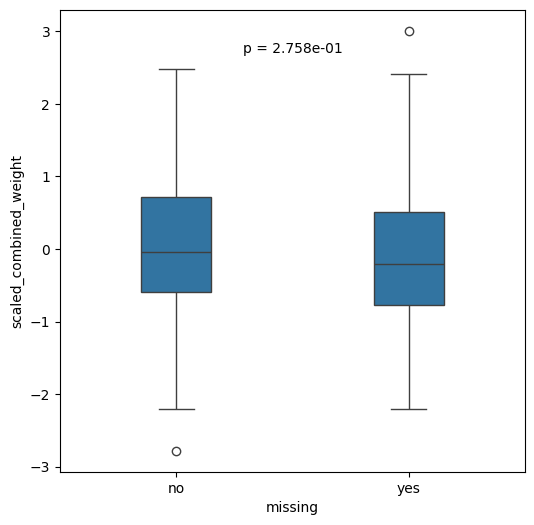

In [15]:
from scipy.stats import ks_2samp, mannwhitneyu

# split data
group1 = weights_df.loc[weights_df['missing'] == 'yes', 'scaled_combined_weight'].dropna()
group2 = weights_df.loc[weights_df['missing'] == 'no', 'scaled_combined_weight'].dropna()

# KS test
ks_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')

# boxplot
plt.figure(figsize=(6,6))
sns.boxplot(data=weights_df, x='missing', y='scaled_combined_weight', width = 0.3)

y_max = weights_df['scaled_combined_weight'].max()
plt.text(0.5, y_max * 0.95,       # 95% of max → stays inside
         f"p = {p_val:.3e}", 
         ha='center', va='top', fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))  # background box

# plt.savefig('../results/pdx_missingGeneWeights.pdf', dpi=600, bbox_inches='tight')
# plt.title("Missing gene weights in PDX data")
plt.show()

Use the missing genes and get their aliases with Rscript get_grch37_ids.R

In [16]:
# read the missing gene synonyms
synonyms_df = pd.read_csv('../results/pdx_missing_synonyms_both_versions.csv', header = 0, index_col = 0)
synonyms_df.head()

,hgnc_symbol_grch37,ensembl_ids,synonyms
1,ANXA8,ENSG00000265190,ANX8;ANXA8L1
2,AREG,ENSG00000109321,SDGF;SDGF;SDGF;SDGF;CRDGF;CRDGF;CRDGF;CRDGF;AR...
3,ARFGAP1,ENSG00000101199,bA261N11.3;FLJ10767;FLJ10767;FLJ10767;HRIHFB22...
4,ARHGAP8,ENSG00000241484,BPGAP1;BPGAP1;FLJ20185;FLJ20185;PP610
5,CACNG8,ENSG00000142408,CACNG6


In [17]:
# remove NaN rows
synonyms_df = synonyms_df.dropna(subset=['synonyms'])

Missing genes - genes in weights df but absent in PDX expression

Given a missing gene, search in PDX all its aliases. if match found, add to a dict

In [18]:
mapping_dict = {}

for missing_gene in missing_genes:
    if missing_gene in synonyms_df['hgnc_symbol_grch37'].values:
        # collect all synonyms (in case there are multiple rows per gene)
        synonyms = ';'.join(synonyms_df.loc[synonyms_df['hgnc_symbol_grch37'] == missing_gene, 'synonyms'].astype(str))
        # print(len(synonyms.split(';')))
        all_synonyms = [s.strip() for s in synonyms.split(';') if s.strip()]

        # get all matches with PDX
        matches = [syn for syn in all_synonyms if syn in scaled_exp_data.columns]
        
        if matches:
            print(missing_gene, len(matches))
            mapping_dict[missing_gene] = matches   # store as list of matches


DSC2 2
VCAM1 1
SYT11 1


In [19]:
mapping_dict

{'DSC2': ['DSC3', 'DSC3'], 'VCAM1': ['L1CAM'], 'SYT11': ['SYT12']}

In [20]:
scaled_exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1156,1.223040,-0.281568,-0.239722,-0.056165,0.349046,0.495508,0.161691,0.223322,-2.318417,0.936671,...,0.128216,-1.113830,0.426968,0.422140,-0.811687,0.598478,1.731267,0.512478,-1.347838,-0.394293
X-1172,-0.670510,-0.422098,-0.003365,0.335989,0.879972,-1.189647,0.071918,1.267778,1.951256,0.522632,...,0.165411,-0.650015,2.082486,2.019813,2.138138,0.702099,-0.149212,-2.807487,0.144577,0.970858
X-1323,0.813815,-1.083482,-1.819266,0.138993,0.464027,-0.422882,4.011339,-1.779191,1.895239,-0.507246,...,-0.246972,-0.659113,-3.314972,-3.165820,-0.611271,0.808388,0.931977,0.095741,1.678327,1.852604
X-1442,-0.670249,-1.827611,0.669076,0.631328,1.222733,-1.510613,0.069342,-1.294691,0.647043,2.688926,...,1.194632,-0.593948,0.067862,0.669403,-0.917524,0.530424,0.641128,-1.261833,0.626786,-0.278981
X-1499,0.734197,-0.053426,1.453467,-1.299430,-0.103464,-1.069801,1.274478,0.432079,-1.234009,1.055798,...,0.323196,0.387513,0.715190,0.573382,-0.888683,0.919607,1.110946,-0.462552,-0.881942,0.027949


In [21]:
# rename the index usin mapping dict
i = 0
for new, old_list in mapping_dict.items():
  for old_id in old_list:
    if old_id in scaled_exp_data.columns:
      scaled_exp_data.rename({old_id: new}, inplace=True)
      i += 1

In [22]:
scaled_exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1156,1.223040,-0.281568,-0.239722,-0.056165,0.349046,0.495508,0.161691,0.223322,-2.318417,0.936671,...,0.128216,-1.113830,0.426968,0.422140,-0.811687,0.598478,1.731267,0.512478,-1.347838,-0.394293
X-1172,-0.670510,-0.422098,-0.003365,0.335989,0.879972,-1.189647,0.071918,1.267778,1.951256,0.522632,...,0.165411,-0.650015,2.082486,2.019813,2.138138,0.702099,-0.149212,-2.807487,0.144577,0.970858
X-1323,0.813815,-1.083482,-1.819266,0.138993,0.464027,-0.422882,4.011339,-1.779191,1.895239,-0.507246,...,-0.246972,-0.659113,-3.314972,-3.165820,-0.611271,0.808388,0.931977,0.095741,1.678327,1.852604
X-1442,-0.670249,-1.827611,0.669076,0.631328,1.222733,-1.510613,0.069342,-1.294691,0.647043,2.688926,...,1.194632,-0.593948,0.067862,0.669403,-0.917524,0.530424,0.641128,-1.261833,0.626786,-0.278981
X-1499,0.734197,-0.053426,1.453467,-1.299430,-0.103464,-1.069801,1.274478,0.432079,-1.234009,1.055798,...,0.323196,0.387513,0.715190,0.573382,-0.888683,0.919607,1.110946,-0.462552,-0.881942,0.027949


In [23]:
common_genes = list(set(goI_list) & set(scaled_exp_data.columns))
len(common_genes)

130

In [24]:
filtered_exp_data = scaled_exp_data[common_genes]

In [25]:
weights_df.head()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight,missing
EGFR,0.360948,0.005513,2.332825,1.599903,no
KLK7,-0.094738,0.000341,-0.578267,-0.389472,yes
SLC4A2,0.283241,-0.004950,1.775886,1.219304,no
PKMP1,0.386586,-0.010572,2.393172,1.641143,yes
TINAGL1,0.087799,0.001058,0.579290,0.401576,no


In [26]:
pdx_weighted_exp = pd.DataFrame(index=scaled_exp_data.index, columns=common_genes)
for gene in common_genes:
  weight = weights_df.loc[gene, 'scaled_combined_weight']
  pdx_weighted_exp[gene] = (scaled_exp_data[gene] * weight).T
pdx_scores = pdx_weighted_exp.sum(axis=1)

In [27]:
# get erlotinib therapy response dataset
clean_data = pd.read_csv('../data/pdx_data/pdx_responses_clean.csv',
                      header=0, index_col = 0)
clean_data.head()

,T0,T5,T10,T15,T20,therapy
Model,,,,,,
X-1156,NaN,61.4,202.95,184.80,391.7,erlotinib
X-1172,NaN,-0.6,74.00,172.05,NaN,erlotinib
X-1323,NaN,-18.6,-18.90,27.60,57.2,erlotinib
X-1442,NaN,-10.4,-3.00,13.60,NaN,erlotinib
X-1499,NaN,10.6,93.20,302.45,NaN,erlotinib


In [28]:
# merge scores and response data
clean_data['pdx_scores'] = pdx_scores
clean_data.head()

,T0,T5,T10,T15,T20,therapy,pdx_scores
Model,,,,,,,
X-1156,NaN,61.4,202.95,184.80,391.7,erlotinib,-6.202504
X-1172,NaN,-0.6,74.00,172.05,NaN,erlotinib,-0.386268
X-1323,NaN,-18.6,-18.90,27.60,57.2,erlotinib,-6.115833
X-1442,NaN,-10.4,-3.00,13.60,NaN,erlotinib,-2.400014
X-1499,NaN,10.6,93.20,302.45,NaN,erlotinib,-25.998447


In [29]:
clean_data['score_cat'] = np.where(clean_data['pdx_scores'] >= np.median(clean_data['pdx_scores']),
                                   'high_score', 'low_score')
clean_data.head()

,T0,T5,T10,T15,T20,therapy,pdx_scores,score_cat
Model,,,,,,,,
X-1156,NaN,61.4,202.95,184.80,391.7,erlotinib,-6.202504,low_score
X-1172,NaN,-0.6,74.00,172.05,NaN,erlotinib,-0.386268,low_score
X-1323,NaN,-18.6,-18.90,27.60,57.2,erlotinib,-6.115833,low_score
X-1442,NaN,-10.4,-3.00,13.60,NaN,erlotinib,-2.400014,low_score
X-1499,NaN,10.6,93.20,302.45,NaN,erlotinib,-25.998447,low_score


<Axes: xlabel='pdx_scores', ylabel='Density'>

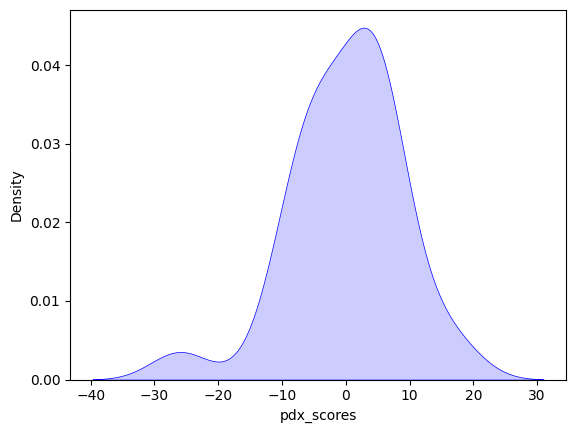

In [30]:
sns.kdeplot(clean_data['pdx_scores'], color='blue', fill=True, alpha=0.2, linewidth = 0.5)

In [31]:
clean_data['score_cat'].value_counts()

score_cat
high_score    13
low_score     12
Name: count, dtype: int64

In [32]:
# create melted df
long_df_data = pd.melt(
    clean_data.reset_index(),  # ensure 'pdx_id' is a column, not index
    id_vars=['Model', 'pdx_scores', 'score_cat'],
    value_vars=['T5', 'T10', 'T15', 'T20'],
    var_name='timepoint',
    value_name='percent_reduction'
)

/tmp/ipykernel_68/1963126796.py:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


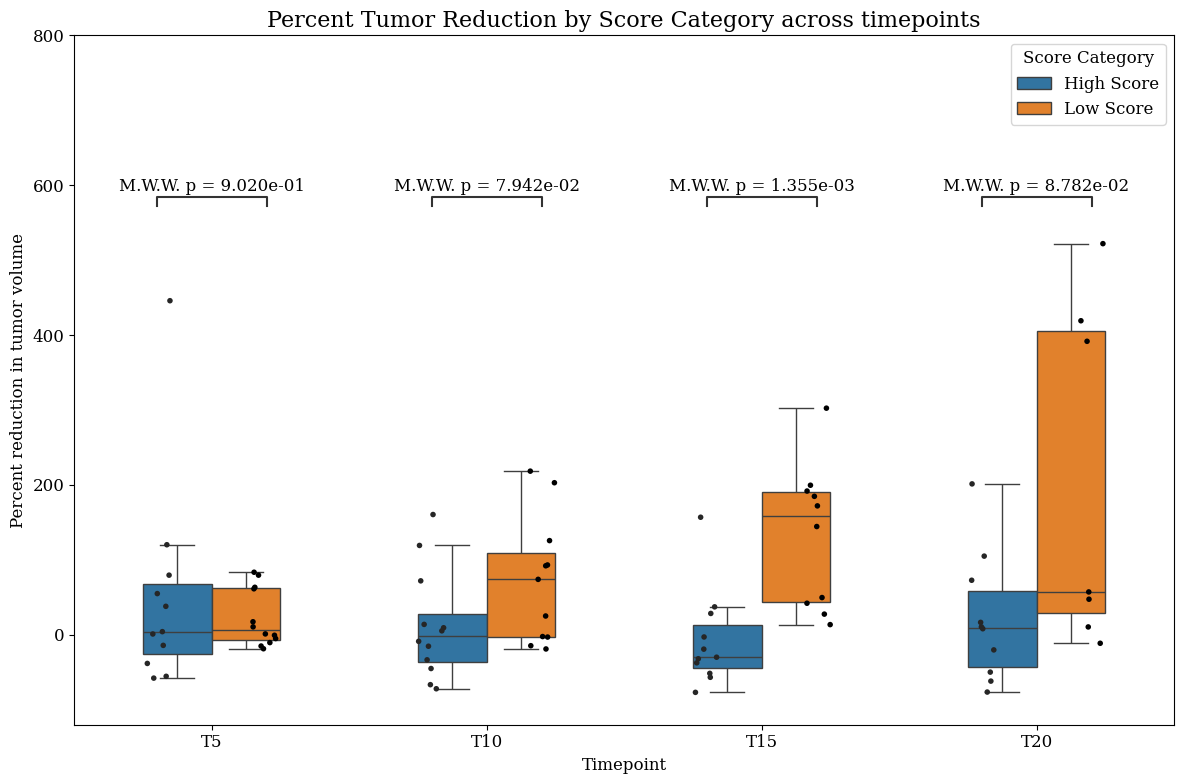

In [34]:
# Set up font and size
from statannotations.Annotator import Annotator
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12  # Increased for better readability
hue_order = ["high_score", "low_score"]
palette = {"high_score": "#1f77b4", "low_score": "#ff7f0e"}

# Set figure size
fig, ax = plt.subplots(figsize=(12,8))

# 1. Draw boxplot
# 1. Draw boxplot with the new, narrower width
sns.boxplot(
    data=long_df_data,
    x="timepoint", y="percent_reduction",
    hue="score_cat", hue_order=hue_order,
    palette=palette,
    ax=ax,
    showfliers=False,
    width=0.5  # <-- The main change here
)

# 2. Overlay stripplot with reduced jitter to match the narrower boxes
sns.stripplot(
    data=long_df_data,
    x="timepoint", y="percent_reduction",
    hue="score_cat", hue_order=hue_order,
    color="black",
    dodge=True,
    jitter=0.1,      # <-- Adjusted to keep points within the box's visual area
    size=4,
    ax=ax
)
# The manual scatter plot loop has been removed as it's no longer needed.

# Define comparisons for p-value annotations
pairs = [
    (("T5", "high_score"), ("T5", "low_score")),
    (("T10", "high_score"), ("T10", "low_score")),
    (("T15", "high_score"), ("T15", "low_score")),
    (("T20", "high_score"), ("T20", "low_score")),
]

# 3. Add p-values using Mann-Whitney U test
annotator = Annotator(ax, pairs, data=long_df_data, x="timepoint", y="percent_reduction", hue="score_cat", hue_order=hue_order)
annotator.configure(
    test='Mann-Whitney',
    text_format='full',
    loc='outside',
    verbose=0 # Hides the statannotations output text
)
annotator.apply_and_annotate()

# 4. Adjust legend
# Adjust legend
handles, labels = ax.get_legend_handles_labels()
# Manually update the labels for better readability
label_map = {'high_score': 'High Score', 'low_score': 'Low Score'}
updated_labels = [label_map.get(lbl, lbl) for lbl in labels]

# Show only the first two handles/labels (for the boxplot)
ax.legend(handles[0:2], updated_labels[0:2], title='Score Category', loc='upper right')

# Final plot adjustments
ax.set_title("Percent Tumor Reduction by Score Category across timepoints", fontsize=16)
ax.set_xlabel('Timepoint', fontsize=12)
ax.set_ylabel('Percent reduction in tumor volume', fontsize=12)
ax.set_ylim(-120, 800)
plt.tight_layout()
# plt.savefig(fname = '../figures/pdx_fourDur_response.pdf', dpi = 600)
plt.show()

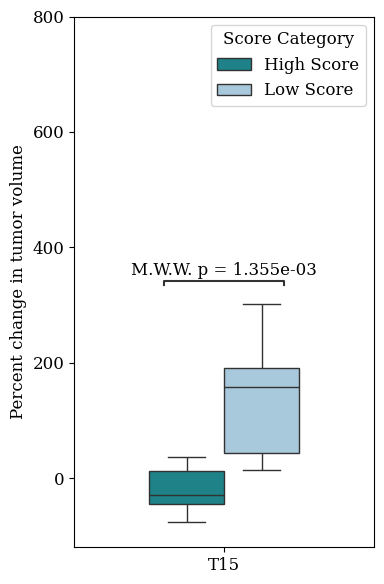

In [36]:
palette = {'high_score': '#0c919a', 'low_score': '#9fcae3'}
# Filter data to only T15
df_T15 = long_df_data[long_df_data["timepoint"] == "T15"]

# Set up font and size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
hue_order = ["high_score", "low_score"]

# Set figure size
fig, ax = plt.subplots(figsize=(4, 6))

# 1. Boxplot
sns.boxplot(
    data=df_T15,
    x="timepoint", y="percent_reduction",
    hue="score_cat", hue_order=hue_order,
    palette=palette,
    ax=ax,
    showfliers=False,
    width=0.5
)

def mannwhitneyu_one_sided(x, y):
    # H0: distributions are the same
    # H1: x < y (i.e. high_score < low_score)
    stat, pval = mannwhitneyu(x, y, alternative="less")
    return stat, pval

pairs = [
    (("T15", "high_score"), ("T15", "low_score")),
]

# 3. Statistical test (only one comparison needed for T15)
pairs = [
    (("T15", "high_score"), ("T15", "low_score")),
]

annotator = Annotator(ax, pairs, data=df_T15, x="timepoint", y="percent_reduction",
                      hue="score_cat", hue_order=hue_order)
annotator.configure(
    test='Mann-Whitney',
    text_format='full',
    loc='outside',
    verbose=0
)
annotator.apply_and_annotate()

# 4. Legend
handles, labels = ax.get_legend_handles_labels()
label_map = {'high_score': 'High Score', 'low_score': 'Low Score'}
updated_labels = [label_map.get(lbl, lbl) for lbl in labels]
ax.legend(handles[0:2], updated_labels[0:2], title='Score Category', loc='upper right')

# Final plot adjustments
# ax.set_title("Percent Tumor Reduction at T15", fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Percent change in tumor volume', fontsize=12)
ax.set_ylim(-120, 800)
plt.tight_layout()
# plt.savefig('../figures/pdx_response_T15.pdf', dpi = 600)
plt.show()


In [37]:
df_T15.head()

,Model,pdx_scores,score_cat,timepoint,percent_reduction
50,X-1156,-6.202504,low_score,T15,184.80
51,X-1172,-0.386268,low_score,T15,172.05
52,X-1323,-6.115833,low_score,T15,27.60
53,X-1442,-2.400014,low_score,T15,13.60
54,X-1499,-25.998447,low_score,T15,302.45


In [38]:
df_T15.groupby('score_cat')['percent_reduction'].describe()

,count,mean,std,min,25%,50%,75%,max
score_cat,,,,,,,,
high_score,11.0,-7.593939,64.525268,-76.8,-44.425,-29.900,12.8000,156.90
low_score,10.0,132.828333,95.168531,13.6,44.025,158.275,190.0875,302.45


In [39]:
other_data = pd.read_csv('../data/pdx_data/pdx_other_data.csv', 
                       header = 0, index_col = 0, sep='\t')

In [40]:
other_data.head()

,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
Model,,,,,,,,,
X-1156,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-1172,erlotinib,single,186.4,14,46.1,12,8.6,14,PD
X-1323,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD
X-1442,erlotinib,single,13.6,11,0.0,11,11.0,11,SD
X-1499,erlotinib,single,307.7,15,98.8,14,9.4,15,PD


In [41]:
clean_data.head()

,T0,T5,T10,T15,T20,therapy,pdx_scores,score_cat
Model,,,,,,,,
X-1156,NaN,61.4,202.95,184.80,391.7,erlotinib,-6.202504,low_score
X-1172,NaN,-0.6,74.00,172.05,NaN,erlotinib,-0.386268,low_score
X-1323,NaN,-18.6,-18.90,27.60,57.2,erlotinib,-6.115833,low_score
X-1442,NaN,-10.4,-3.00,13.60,NaN,erlotinib,-2.400014,low_score
X-1499,NaN,10.6,93.20,302.45,NaN,erlotinib,-25.998447,low_score


In [42]:
merged_df = pd.concat([clean_data, other_data], join='inner', axis = 1)
df2 = merged_df.sort_values(by = 'BestAvgResponse', axis=0, ascending=False)

In [43]:
merged_df.head()

,T0,T5,T10,T15,T20,therapy,pdx_scores,score_cat,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
Model,,,,,,,,,,,,,,,,,
X-1156,NaN,61.4,202.95,184.80,391.7,erlotinib,-6.202504,low_score,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-1172,NaN,-0.6,74.00,172.05,NaN,erlotinib,-0.386268,low_score,erlotinib,single,186.4,14,46.1,12,8.6,14,PD
X-1323,NaN,-18.6,-18.90,27.60,57.2,erlotinib,-6.115833,low_score,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD
X-1442,NaN,-10.4,-3.00,13.60,NaN,erlotinib,-2.400014,low_score,erlotinib,single,13.6,11,0.0,11,11.0,11,SD
X-1499,NaN,10.6,93.20,302.45,NaN,erlotinib,-25.998447,low_score,erlotinib,single,307.7,15,98.8,14,9.4,15,PD


In [44]:
conditions = [
    (merged_df["BestResponse"] < -95) & (merged_df["BestAvgResponse"] < -40),  # mCR
    (merged_df["BestResponse"] < -50) & (merged_df["BestAvgResponse"] < -20),  # mPR
    (merged_df["BestResponse"] < 35) & (merged_df["BestAvgResponse"] < 30)    # mSD
]

# Define corresponding categories
choices = ["mCR", "mPR", "mSD"]

# Apply conditions, default "mPD"
merged_df["mRECIST"] = np.select(conditions, choices, default="mPD")

In [45]:
pd.crosstab(merged_df["mRECIST"], merged_df["score_cat"])

score_cat,high_score,low_score
mRECIST,,
mPD,5,9
mPR,3,0
mSD,5,3


In [46]:
df2.head()

,T0,T5,T10,T15,T20,therapy,pdx_scores,score_cat,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
Model,,,,,,,,,,,,,,,,,
X-4819,NaN,445.85,NaN,NaN,NaN,erlotinib,6.077908,high_score,erlotinib,single,553.9,5,297.2,5,3.0,5,PD
X-1156,NaN,61.40,202.95,184.80,391.7,erlotinib,-6.202504,low_score,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-2094,NaN,63.40,125.70,199.60,419.1,erlotinib,-7.302763,low_score,erlotinib,single,494.3,20,102.9,13,6.3,20,PD
X-1499,NaN,10.60,93.20,302.45,NaN,erlotinib,-25.998447,low_score,erlotinib,single,307.7,15,98.8,14,9.4,15,PD
X-1934,NaN,83.50,218.40,NaN,NaN,erlotinib,-5.035992,low_score,erlotinib,single,218.4,7,96.4,7,3.3,7,PD


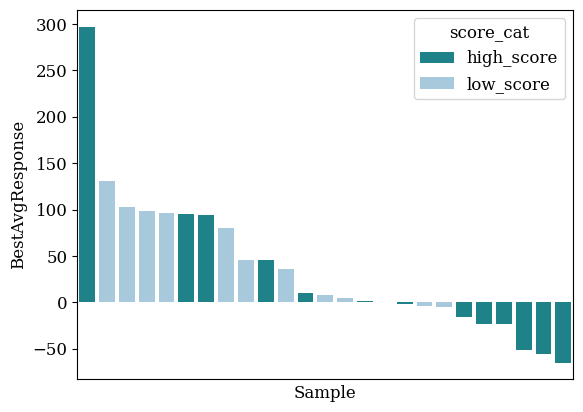

In [47]:
palette = {'high_score': '#0c919a', 'low_score': '#9fcae3'}
sns.barplot(data = df2, x = df2.index, y = 'BestAvgResponse', hue = 'score_cat', palette = palette)
plt.xticks([])
plt.xlabel('Sample')
# plt.savefig('../figures/pdx_bestAvgResponses.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [48]:
merged_df.to_csv('../results/pdx_score_responses.csv', index=True)